In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
database_path = "Resources/hawaii.sqlite"
engine = create_engine(f"sqlite:///{database_path}")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

In [6]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
now = date.today()
twelve_months = now - relativedelta(months=+12)
twelve_months

datetime.date(2019, 2, 26)

In [11]:
results = session.query(Measurement.date, Measurement.prcp).all()

In [12]:
df = pd.DataFrame(results, columns=['date', 'prcp'])
df = df.dropna()
df

,date,prcp
0,2010-01-01,0.08
1,2010-01-02,0.00
2,2010-01-03,0.00
3,2010-01-04,0.00
5,2010-01-07,0.06
...,...,...
19543,2017-08-17,0.13
19545,2017-08-19,0.09
19547,2017-08-21,0.56
19548,2017-08-22,0.50


In [13]:
data_2010 = df.loc[df['date'] > '2009-12-31']
data_2010 = df.loc[df['date'] < '2011-01-01']
date = list(data_2010['date'])
prcp = list(data_2010['prcp'])

In [14]:
data_2010

,date,prcp
0,2010-01-01,0.08
1,2010-01-02,0.00
2,2010-01-03,0.00
3,2010-01-04,0.00
5,2010-01-07,0.06
...,...,...
17283,2010-12-27,0.02
17284,2010-12-28,0.04
17285,2010-12-29,0.19
17286,2010-12-30,0.30


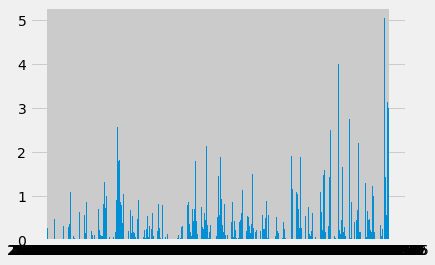

In [16]:
fig, ax = plt.subplots()
ax.bar(date, prcp)

plt.show()